# Nerual Network Basics

## Activation Functions
- ReLU is short for “rectified linear unit,” but that is just a fancy way of saying “turn  negative values into 0.”
- Sigmoid is used in logistic regression and binary classification in general. Simply put, it normalize a value into a probability [0, 1]

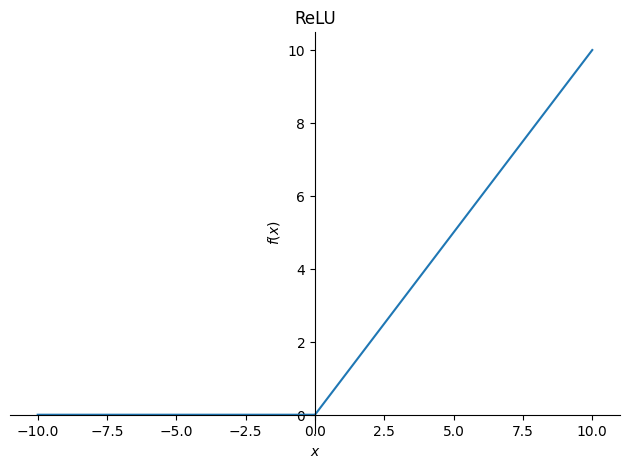

In [4]:
from sympy import *

# plot relu
x = symbols("x")
relu = Max(0, x)
plot(relu, title="ReLU")

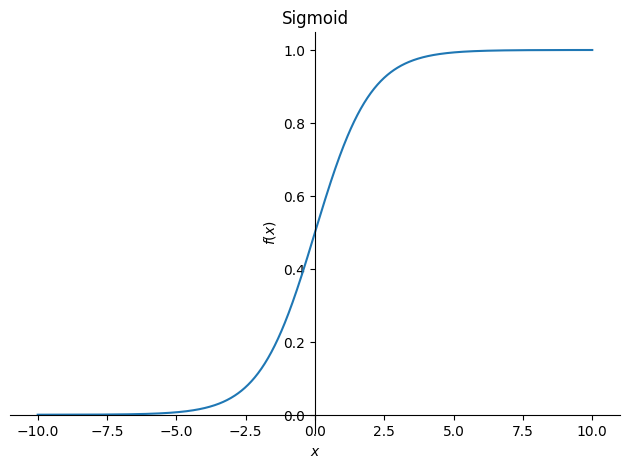

In [5]:
# plot sigmoid
x = symbols("x")
sigmoid = 1 / (1 + exp(-x))
plot(sigmoid, title="Sigmoid")

In [7]:
x,y = symbols('x y')
z = x**2 / sqrt(2*y**3 - 1)
print(latex(z))
# prints # \frac{x^{2}}{\sqrt{2 y^{3} - 1}}

\frac{x^{2}}{\sqrt{2 y^{3} - 1}}


# Implement a NN using Numpy